In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as sm
import sklearn.gaussian_process as gp
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
df = pd.read_csv(r'downloads\aquaponics\IoTpond4.csv')

C:\Users\Muguntha Madhavan\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3135: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89844 entries, 0 to 89843
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              89844 non-null  object 
 1   entry_id                89797 non-null  float64
 2   Temperature(C)          89797 non-null  float64
 3   Turbidity(NTU)          89797 non-null  float64
 4   Dissolved Oxygen(g/ml)  89797 non-null  float64
 5   PH                      89797 non-null  float64
 6   Ammonia(g/ml)           89742 non-null  float64
 7   Nitrate(g/ml)           89797 non-null  float64
 8   Population              89844 non-null  int64  
 9   Fish_Length(cm)         89844 non-null  object 
 10  Fish_Weight(g)          89844 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 7.5+ MB


In [4]:
org_df = df
#Cleaning the data remvoing Nan,null,none values from dataframe
df = df.dropna(axis = 0)
#Desired range of parameters
#ph = 6-8
#dissolved_oxy = 5-20
#temp = 20-30
#turb = 80-90 
#ammonia = 0-1
#Filterng Data based on range
df = df[(df["PH"] <= 8) & (df["PH"] >= 6) & (df["Dissolved Oxygen(g/ml)"] <= 20) & (df["Dissolved Oxygen(g/ml)"] >= 5) & 
   (df["Temperature(C)"] <= 30) & (df["Temperature(C)"] >= 20) & (df["Turbidity(NTU)"] <= 90) & (df["Turbidity(NTU)"] >= 80) &
(df["Ammonia(g/ml)"] <= 1) & (df["Ammonia(g/ml)"] >= 0)]


In [5]:
#Getting all the columns 
dates = (df.loc[:,["created_at"]]).values.tolist() 
dates = [item for sublist in dates for item in sublist]
dates = [date.replace(" CET","") for date in dates]#Coverting to iso date and time 
dates = [datetime.fromisoformat(date).timestamp() for date in dates]#Converting date and time to timestamps
dates = np.array(dates)
ph =  (df["PH"]).values
dis_o2 = (df["Dissolved Oxygen(g/ml)"]).values
turb =  (df["Turbidity(NTU)"]).values
temp =  (df["Temperature(C)"]).values
amm_con = (df["Ammonia(g/ml)"]).values
nit_con = (df["Nitrate(g/ml)"]).values
fish_len = (df["Fish_Length(cm)"]).values.astype(float)
fish_wei = (df["Fish_Weight(g)"]).values
pop = (df["Population"]).values

Dependent Variables : Fish_Length,Fish_Weight 
Independent Variables : Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Times

Text(0, 0.5, 'Fish_Weight(g)')

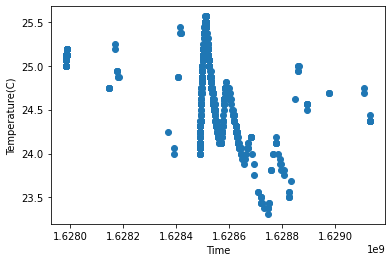

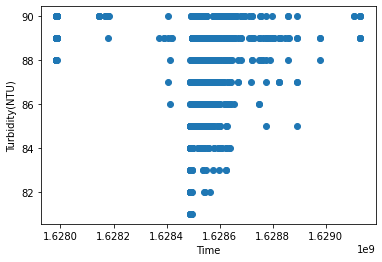

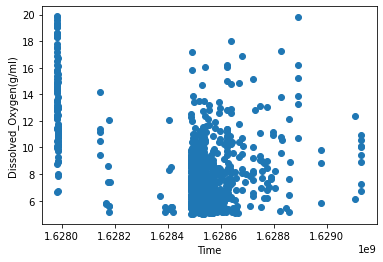

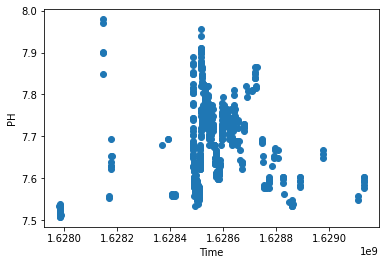

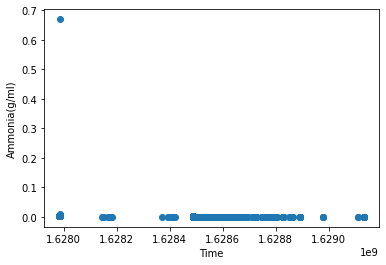

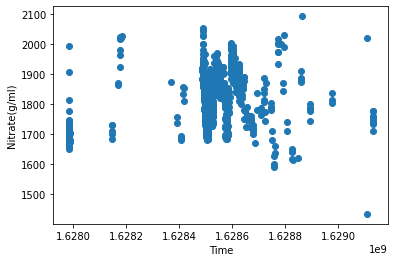

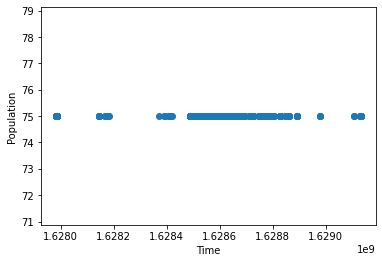

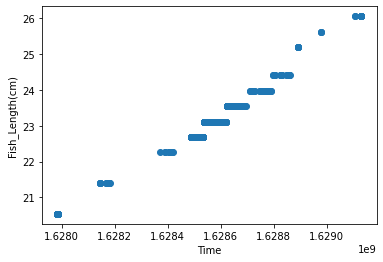

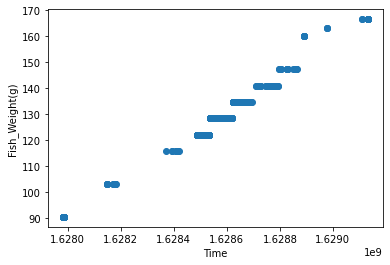

In [6]:
#Visualizing Data
plt.figure(1)
plt.scatter(dates,temp)
plt.xlabel("Time")
plt.ylabel("Temperature(C)")
plt.figure(2)
plt.scatter(dates,turb)
plt.xlabel("Time")
plt.ylabel("Turbidity(NTU)")
plt.figure(3)
plt.scatter(dates,dis_o2)
plt.xlabel("Time")
plt.ylabel("Dissolved_Oxygen(g/ml)")
plt.figure(4)
plt.scatter(dates,ph)
plt.xlabel("Time")
plt.ylabel("PH")
plt.figure(5)
plt.scatter(dates,amm_con)
plt.xlabel("Time")
plt.ylabel("Ammonia(g/ml)")
plt.figure(6)
plt.scatter(dates,nit_con)
plt.xlabel("Time")
plt.ylabel("Nitrate(g/ml)")
plt.figure(7)
plt.scatter(dates,pop)
plt.xlabel("Time")
plt.ylabel("Population")
plt.figure(8)
plt.scatter(dates,fish_len)
plt.xlabel("Time")
plt.ylabel("Fish_Length(cm)")
plt.figure(9)
plt.scatter(dates,fish_wei)
plt.xlabel("Time")
plt.ylabel("Fish_Weight(g)")

In [7]:
#Linear Regression Dep var: Fish_length Indep var:Temp,nit,amm,dis_o2,ph,turb
#Population is not chosen as it doesnt change over time
ind_var = np.concatenate((temp.reshape(-1,1),nit_con.reshape(-1,1),amm_con.reshape(-1,1),dis_o2.reshape(-1,1),ph.reshape(-1,1)
                          ,turb.reshape(-1,1),dates.reshape(-1,1)),axis = 1)
train_samps = int(0.7*len(dates))# Training Dataset Length
test_samps = len(dates)-train_samps# Testing Dataset Length
fl_tr,ind_tr = fish_len[:train_samps],ind_var[:train_samps]
fl_ts,ind_ts = fish_len[train_samps:],ind_var[train_samps:]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(ind_tr,fl_tr)
fl_pred = lin_reg.predict(ind_ts)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))


fw_tr = fish_wei[:train_samps]
fw_ts = fish_wei[train_samps:]

lin_reg.fit(ind_tr,fw_tr)
fw_pred = lin_reg.predict(ind_ts)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.14
Mean squared error(MSE) = 0.0491
Root Mean squared error(RMSE) = 0.22
Root Mean squared error(RMSLE) = 0.0086
R2-Score = 0.89
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 1.95
Mean squared error(MSE) = 8.34
Root Mean squared error(RMSE) = 2.89
Root Mean squared error(RMSLE) = 0.02
R2-Score = 0.9


In [8]:
#Ridge Regression Dep Var: Fish_length Indep var:Temp,nit,amm,dis_o2,ph,turb
rdg = linear_model.Ridge(alpha = 0.5)
rdg.fit(ind_tr,fl_tr)
fl_pred = rdg.predict(ind_ts)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared log error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score",round(sm.r2_score(fl_ts,fl_pred),2))

rdg.fit(ind_tr,fw_tr)
fw_pred = rdg.predict(ind_ts)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.14
Mean squared error(MSE) = 0.0495
Root Mean squared error(RMSE) = 0.22
Root Mean squared log error(RMSLE) = 0.0087
R2-Score 0.89
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 1.96
Mean squared error(MSE) = 8.41
Root Mean squared error(RMSE) = 2.9
Root Mean squared error(RMSLE) = 0.02
R2-Score = 0.9


In [9]:
#Lasso Regression
las = linear_model.Lasso(alpha = 0.5)
las.fit(ind_tr,fl_tr)
fl_pred = las.predict(ind_ts)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Rooot Mean squared Log error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score",round(sm.r2_score(fl_ts,fl_pred),2)) 

las.fit(ind_tr,fw_tr)
fw_pred = las.predict(ind_ts)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.23
Mean squared error(MSE) = 0.09
Root Mean squared error(RMSE) = 0.3
Rooot Mean squared Log error(RMSLE) = 0.0119
R2-Score 0.8
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 3.22
Mean squared error(MSE) = 16.99
Root Mean squared error(RMSE) = 4.12
Root Mean squared error(RMSLE) = 0.03
R2-Score = 0.8


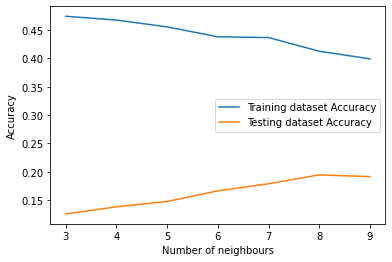

In [10]:
#K-Nearest Neighbour 
# Dep var : Turb, indep:nit_con,pop
indvr_int = np.transpose(np.array([nit_con,pop]))
tur_tr,indvr_tr = turb[:train_samps],indvr_int[:train_samps] #Training Set
tur_ts,indvr_ts = turb[train_samps:],indvr_int[train_samps:] #Testing Set
tr_scrs = []
ts_scrs = []
num_nei = [3,4,5,6,7,8,9]
for a in num_nei:
    knn = KNeighborsClassifier(n_neighbors = a)
    knn.fit(indvr_tr,tur_tr.ravel())
    ts_scrs.append(knn.score(indvr_ts,tur_ts))
    tr_scrs.append(knn.score(indvr_tr,tur_tr))

plt.plot(num_nei, tr_scrs, label = 'Training dataset Accuracy')
plt.plot(num_nei,ts_scrs,label = 'Testing dataset Accuracy')
plt.legend()
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy")
plt.show()

In [11]:
#Polynomial Regression
poly = pf(degree = 2)
tr_poly = poly.fit_transform(ind_tr)
ts_poly = poly.fit_transform(ind_ts)
poly.fit(tr_poly,fl_tr)

linreg = linear_model.LinearRegression()
linreg.fit(tr_poly,fl_tr)
fl_pred = linreg.predict(ts_poly)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

poly.fit(tr_poly,fw_tr)
linreg.fit(tr_poly,fw_tr)
fw_pred = linreg.predict(ts_poly)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred),2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.1
Mean squared error(MSE) = 0.02
Root Mean squared error(RMSE) = 0.14
Root Mean squared error(RMSLE) = 0.01
R2-Score = 0.96
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 1.66
Mean squared error(MSE) = 5.43
Root Mean squared error(RMSE) = 2.33
Root Mean squared error(RMSLE) = 0.02
R2-Score = 0.94


In [12]:
#Gaussian Regression
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

gpr.fit(ind_tr[:,0:6],fl_tr)
fl_pred = gpr.predict(ind_ts[:,0:6])

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

gpr.fit(ind_tr[:,0:6],fw_tr)
fw_pred = gpr.predict(ind_ts[:,0:6])

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 1.04
Mean squared error(MSE) = 2.24
Root Mean squared error(RMSE) = 1.5
Root Mean squared error(RMSLE) = 0.06
R2-Score = -4.0
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 127.58
Mean squared error(MSE) = 16362.36
Root Mean squared error(RMSE) = 127.92
Root Mean squared error(RMSLE) = 2.88
R2-Score = -189.8


C:\Users\Muguntha Madhavan\AppData\Roaming\Python\Python38\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.4
Mean squared error(MSE) = 0.61
Root Mean squared error(RMSE) = 0.78
Root Mean squared error(RMSLE) = 0.03
R2-Score = -0.35
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 127.58
Mean squared error(MSE) = 16362.36
Root Mean squared error(RMSE) = 127.92
Root Mean squared error(RMSLE) = 2.88
R2-Score = -189.8


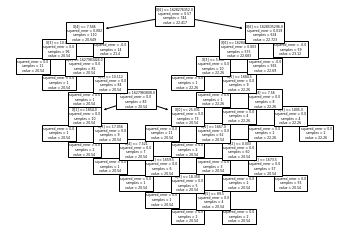

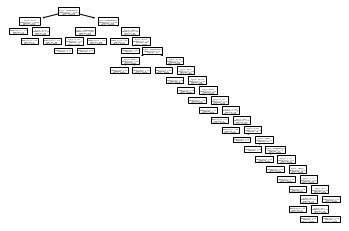

In [13]:
#Decision Tree
dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(ind_tr,fl_tr)
fl_pred =dt_reg.predict(ind_ts)

tree.plot_tree(dt_reg)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

dt_reg2 = DecisionTreeRegressor(random_state = 0)
dt_reg2.fit(ind_tr,fw_tr)
fl_pred =dt_reg2.predict(ind_ts)

plt.figure(2)
tree.plot_tree(dt_reg2)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.4
Mean squared error(MSE) = 0.61
Root Mean squared error(RMSE) = 0.78
Root Mean squared error(RMSLE) = 0.03
R2-Score = -0.35
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 5.7
Mean squared error(MSE) = 118.29
Root Mean squared error(RMSE) = 10.88
Root Mean squared error(RMSLE) = 0.08
R2-Score = -0.38


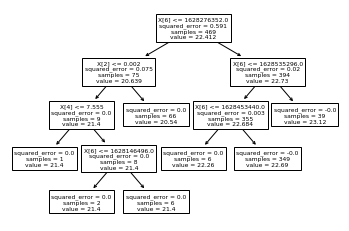

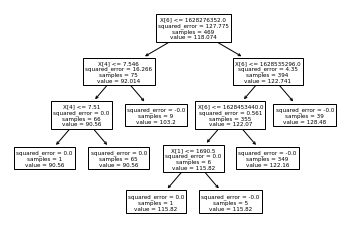

In [14]:
#Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(ind_tr,fl_tr)
fl_pred = rf.predict(ind_ts)

tree.plot_tree(rf.estimators_[0])

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))


rf.fit(ind_tr,fw_tr)
fw_pred = rf.predict(ind_ts)

plt.figure(2)
tree.plot_tree(rf.estimators_[0])

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

In [15]:
#RANSAC - Robust regression
ransac = linear_model.RANSACRegressor()
ransac.fit(ind_tr,fl_tr)
fl_pred = ransac.predict(ind_ts)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

ransac.fit(ind_tr,fw_tr)
fw_pred = ransac.predict(ind_ts)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.83
Mean squared error(MSE) = 1.14
Root Mean squared error(RMSE) = 1.07
Root Mean squared error(RMSLE) = 0.04
R2-Score = -1.53
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 12.02
Mean squared error(MSE) = 230.34
Root Mean squared error(RMSE) = 15.18
Root Mean squared error(RMSLE) = 0.11
R2-Score = -1.69


In [16]:
#SVM Support Vector Regrssion
svr=SVR(C=1.0, epsilon=0.2, kernel='rbf')
svr.fit(ind_tr,fl_tr)
fl_pred = svr.predict(ind_ts)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

svr.fit(ind_tr,fw_tr)
fw_pred = svr.predict(ind_ts)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 1.03
Mean squared error(MSE) = 1.51
Root Mean squared error(RMSE) = 1.23
Root Mean squared error(RMSLE) = 0.05
R2-Score = -2.36
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 12.22
Mean squared error(MSE) = 235.19
Root Mean squared error(RMSE) = 15.34
Root Mean squared error(RMSLE) = 0.11
R2-Score = -1.74


Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.22
Mean squared error(MSE) = 0.084
Root Mean squared error(RMSE) = 0.29
Root Mean squared error(RMSLE) = 0.0115
R2-Score = 0.81
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 3.06
Mean squared error(MSE) = 15.4
Root Mean squared error(RMSE) = 3.92
Root Mean squared error(RMSLE) = 0.03
R2-Score = 0.82


Text(0, 0.5, 'Fish_weight(g)')

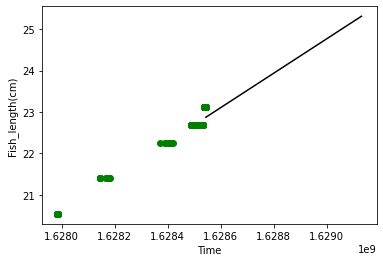

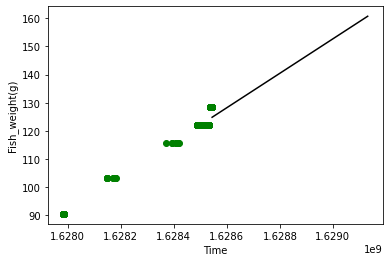

In [17]:
#Linear Regression with only one independent variable
dates_tr = dates[:train_samps]
dates_ts = dates[train_samps:]
lin_reg = linear_model.LinearRegression()
lin_reg.fit(dates_tr.reshape(-1,1),fl_tr)
fl_pred = lin_reg.predict(dates_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(dates_tr,fl_tr,color = 'g')
plt.plot(dates_ts,fl_pred, color = 'k')
plt.xlabel("Time")
plt.ylabel("Fish_length(cm)")

lin_reg.fit(dates_tr.reshape(-1,1),fw_tr)
fw_pred = lin_reg.predict(dates_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(dates_tr,fw_tr,color = 'g')
plt.plot(dates_ts,fw_pred, color = 'k')
plt.xlabel("Time")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.9
Mean squared error(MSE) = 1.2449
Root Mean squared error(RMSE) = 1.12
Root Mean squared error(RMSLE) = 0.0453
R2-Score = -1.77
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 13.07
Mean squared error(MSE) = 253.29
Root Mean squared error(RMSE) = 15.92
Root Mean squared error(RMSLE) = 0.12
R2-Score = -1.95


Text(0, 0.5, 'Fish_weight(g)')

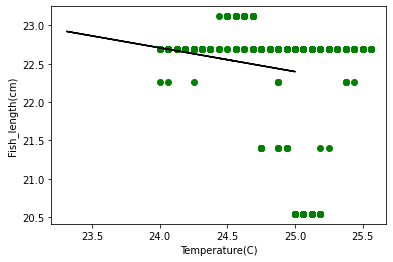

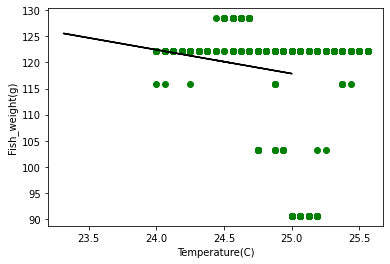

In [18]:
#Ridge Regression Ind Var: Temp
temp_tr = temp[:train_samps]
temp_ts = temp[train_samps:]
rdg = linear_model.Ridge(alpha = 0.5)
rdg.fit(temp_tr.reshape(-1,1),fl_tr)
fl_pred = rdg.predict(temp_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(temp_tr,fl_tr,color = 'g')
plt.plot(temp_ts,fl_pred, color = 'k')
plt.xlabel("Temperature(C)")
plt.ylabel("Fish_length(cm)")

rdg.fit(temp_tr.reshape(-1,1),fw_tr)
fw_pred = rdg.predict(temp_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(temp_tr,fw_tr,color = 'g')
plt.plot(temp_ts,fw_pred, color = 'k')
plt.xlabel("Temperature(C)")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 1.1
Mean squared error(MSE) = 1.6651
Root Mean squared error(RMSE) = 1.29
Root Mean squared error(RMSLE) = 0.0528
R2-Score = -2.71
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 16.33
Mean squared error(MSE) = 375.05
Root Mean squared error(RMSE) = 19.37
Root Mean squared error(RMSLE) = 0.15
R2-Score = -3.37


Text(0, 0.5, 'Fish_weight(g)')

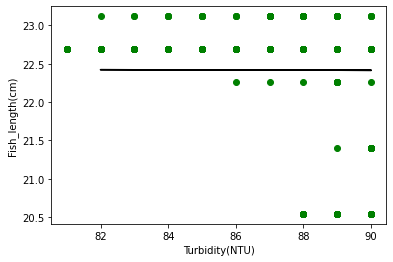

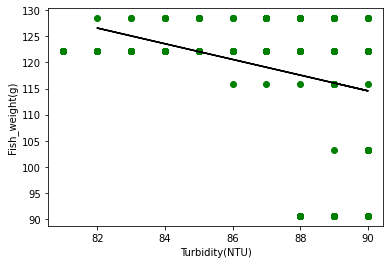

In [19]:
#Lasso Regression Ind Var: Turb
turb_tr = turb[:train_samps]
turb_ts = turb[train_samps:]
las = linear_model.Lasso(alpha = 0.5)
las.fit(turb_tr.reshape(-1,1),fl_tr)
fl_pred = las.predict(turb_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(turb_tr,fl_tr,color = 'g')
plt.plot(turb_ts,fl_pred, color = 'k')
plt.xlabel("Turbidity(NTU)")
plt.ylabel("Fish_length(cm)")

rdg.fit(turb_tr.reshape(-1,1),fw_tr)
fw_pred = rdg.predict(turb_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(turb_tr,fw_tr,color = 'g')
plt.plot(turb_ts,fw_pred, color = 'k')
plt.xlabel("Turbidity(NTU)")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 1.11
Mean squared error(MSE) = 2.1374
Root Mean squared error(RMSE) = 1.46
Root Mean squared error(RMSLE) = 0.0606
R2-Score = -3.76
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 16.13
Mean squared error(MSE) = 445.44
Root Mean squared error(RMSE) = 21.11
Root Mean squared error(RMSLE) = 0.17
R2-Score = -4.19


Text(0, 0.5, 'Fish_weight(g)')

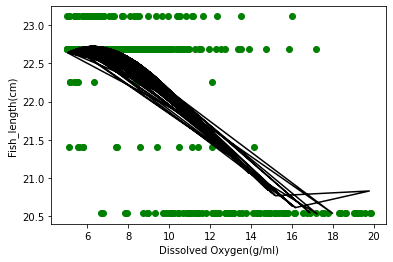

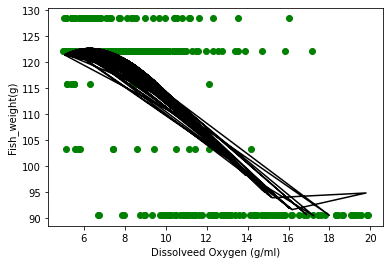

In [20]:
#Polynomial Regression Ind Var: Dis_o2 
diso2_tr = dis_o2[:train_samps]
diso2_ts = dis_o2[train_samps:]
poly = pf(degree = 3)
tr_poly = poly.fit_transform(diso2_tr.reshape(-1,1))
ts_poly = poly.fit_transform(diso2_ts.reshape(-1,1))
poly.fit(tr_poly,fl_tr)

linreg = linear_model.LinearRegression()
linreg.fit(tr_poly,fl_tr)
fl_pred = linreg.predict(ts_poly)

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(diso2_tr,fl_tr,color = 'g')
plt.plot(diso2_ts,fl_pred, color = 'k')
plt.xlabel("Dissolved Oxygen(g/ml)")
plt.ylabel("Fish_length(cm)")

poly.fit(tr_poly,fw_tr)
linreg.fit(tr_poly,fw_tr)
fw_pred = linreg.predict(ts_poly)

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(diso2_tr,fw_tr,color = 'g')
plt.plot(diso2_ts,fw_pred, color = 'k')
plt.xlabel("Dissolveed Oxygen (g/ml)")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.86
Mean squared error(MSE) = 1.2518
Root Mean squared error(RMSE) = 1.12
Root Mean squared error(RMSLE) = 0.0455
R2-Score = -1.79
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 16.13
Mean squared error(MSE) = 445.44
Root Mean squared error(RMSE) = 21.11
Root Mean squared error(RMSLE) = 0.17
R2-Score = -4.19


C:\Users\Muguntha Madhavan\AppData\Roaming\Python\Python38\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'Fish_weight(g)')

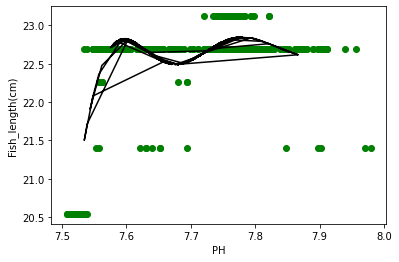

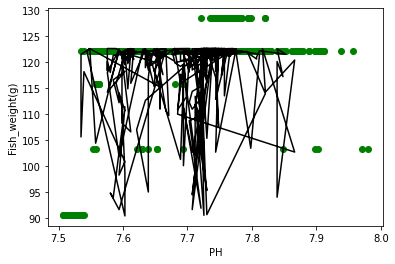

In [21]:
#Gaussian Regression Ind var: PH
ph_tr = ph[:train_samps]
ph_ts = ph[train_samps:]
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

gpr.fit(ph_tr.reshape(-1,1),fl_tr)
fl_pred = gpr.predict(ph_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(ph_tr,fl_tr,color = 'g')
plt.plot(ph_ts,fl_pred, color = 'k')
plt.xlabel("PH")
plt.ylabel("Fish_length(cm)")

gpr.fit(ph_tr.reshape(-1,1),fw_tr)
fW_pred = gpr.predict(ph_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(ph_tr,fw_tr,color = 'g')
plt.plot(ph_ts,fw_pred, color = 'k')
plt.xlabel("PH")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.83
Mean squared error(MSE) = 1.136
Root Mean squared error(RMSE) = 1.07
Root Mean squared error(RMSLE) = 0.0431
R2-Score = -1.53
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 12.02
Mean squared error(MSE) = 230.34
Root Mean squared error(RMSE) = 15.18
Root Mean squared error(RMSLE) = 0.11
R2-Score = -1.69


Text(0, 0.5, 'Fish_weight(g)')

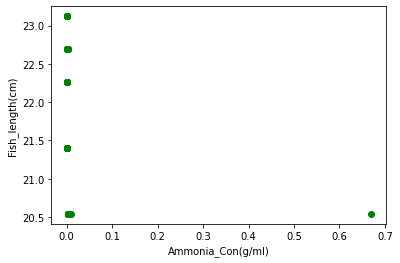

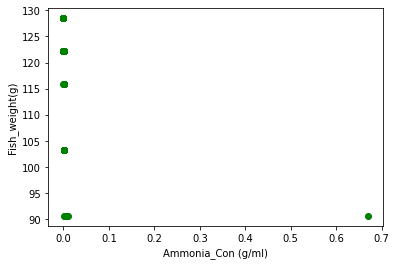

In [22]:
#Ransac Ind var: Amm_con
amm_tr = amm_con[:train_samps]
amm_ts = amm_con[train_samps:]
ransac = linear_model.RANSACRegressor()

ransac.fit(amm_tr.reshape(-1,1),fl_tr)
fl_pred = ransac.predict(amm_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 4))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 4))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(amm_tr,fl_tr,color = 'g')
plt.plot(amm_ts,fl_pred, color = 'k')
plt.xlabel("Ammonia_Con(g/ml)")
plt.ylabel("Fish_length(cm)")

ransac.fit(amm_tr.reshape(-1,1),fw_tr)
fw_pred = ransac.predict(amm_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(amm_tr,fw_tr,color = 'g')
plt.plot(amm_ts,fw_pred, color = 'k')
plt.xlabel("Ammonia_Con (g/ml)")
plt.ylabel("Fish_weight(g)")

Regressor model performance(Length of Fish):
Mean absolute error(MAE) = 0.92
Mean squared error(MSE) = 1.8
Root Mean squared error(RMSE) = 1.34
Root Mean squared error(RMSLE) = 0.06
R2-Score = -3.0
Regressor model performance(Weight of Fish):
Mean absolute error(MAE) = 13.02
Mean squared error(MSE) = 280.63
Root Mean squared error(RMSE) = 16.75
Root Mean squared error(RMSLE) = 0.13
R2-Score = -2.27


Text(0, 0.5, 'Fish_weight(g)')

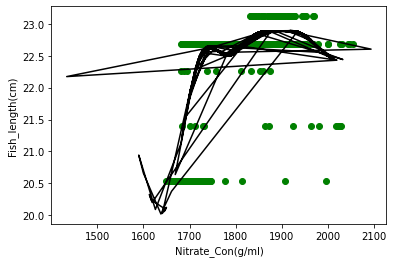

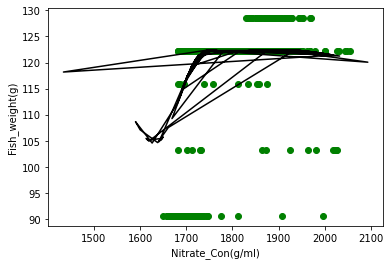

In [23]:
#Support Vector Reggresion
nit_tr = nit_con[:train_samps]
nit_ts = nit_con[train_samps:]
svr=SVR(C=1.0, epsilon=0.2, kernel='rbf')
svr.fit(nit_tr.reshape(-1,1),fl_tr)
fl_pred = svr.predict(nit_ts.reshape(-1,1))

print("Regressor model performance(Length of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fl_ts, fl_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fl_ts, fl_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fl_ts, fl_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fl_ts, fl_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fl_ts, fl_pred), 2))

plt.figure(1)
plt.scatter(nit_tr,fl_tr,color = 'g')
plt.plot(nit_ts,fl_pred, color = 'k')
plt.xlabel("Nitrate_Con(g/ml)")
plt.ylabel("Fish_length(cm)")

svr.fit(nit_tr.reshape(-1,1),fw_tr)
fw_pred = svr.predict(nit_ts.reshape(-1,1))

print("Regressor model performance(Weight of Fish):")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(fw_ts, fw_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(fw_ts, fw_pred), 2))
print("Root Mean squared error(RMSE) =", round(sm.mean_squared_error(fw_ts, fw_pred,squared = False), 2))
print("Root Mean squared error(RMSLE) =", round(sm.mean_squared_log_error(fw_ts, fw_pred,squared = False), 2))
print("R2-Score =", round(sm.r2_score(fw_ts, fw_pred), 2))

plt.figure(2)
plt.scatter(nit_tr,fw_tr,color = 'g')
plt.plot(nit_ts,fw_pred, color = 'k')
plt.xlabel("Nitrate_Con(g/ml)")
plt.ylabel("Fish_weight(g)")